# GPS vs Drone Telemetry Comparison

This notebook compares UBX GPS data with DJI drone telemetry data using the STOUT database integration. It provides a quick comparison between the CSV produced by DATCON and the decrypted data by PILS

## Cell 1: Import Required Libraries

In [9]:
import sys
from pathlib import Path
from datetime import datetime, timedelta
import importlib

import matplotlib
%matplotlib widget

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import polars as pl
from IPython.display import display, Image

# Add paths for imports
sys.path.insert(0, str(Path.cwd()))
sys.path.insert(0, str(Path("/home/stout")))
sys.path.insert(0, str(Path("/home/gabriele/Documents/data_loader")))

# Force complete reload of pils modules
modules_to_remove = [mod for mod in sys.modules.keys() if mod.startswith('pils')]
for mod in modules_to_remove:
    del sys.modules[mod]

# Import the StoutDataLoader - handles all data loading
from pils.loader import StoutLoader
from pils import Flight

print("✓ All libraries imported successfully")
print(f"✓ Reloaded {len(modules_to_remove)} pils modules")

✓ All libraries imported successfully
✓ Reloaded 26 pils modules


## Cell 2: Define All Helper Functions

In [7]:
def compare_coordinates(gps_df, drone_df, source_type='dat'):
    """Compare GPS coordinates between UBX and drone telemetry using time-based matching.
    
    Args:
        gps_df: GPS dataframe
        drone_df: Drone dataframe
        source_type: 'dat' or 'csv' - determines column name format
    """
    comparison = {}
    
    # Define column names based on source type
    if source_type == 'csv':
        lat_col = "GPS:Lat[degrees]"
        lat_col = "RTKdata:Lat_P"
        lon_col = "GPS:Long[degrees]"
        lon_col = "RTKdata:Lon_P"
    else:  # dat
        lat_col = "GPS:latitude"
        lon_col = "GPS:longitude"
    
    # Ensure both dataframes have timestamp column
    if "timestamp" not in gps_df.columns or "timestamp" not in drone_df.columns:
        print("Warning: timestamp column missing in one or both dataframes")
        return comparison
    
    # Sort both dataframes by timestamp
    gps_df = gps_df.sort("timestamp")
    drone_df = drone_df.sort("timestamp")
    
    # Find common time range
    gps_time_min = gps_df["timestamp"].min()
    gps_time_max = gps_df["timestamp"].max()
    drone_time_min = drone_df["timestamp"].min()
    drone_time_max = drone_df["timestamp"].max()
    
    common_time_min = max(gps_time_min, drone_time_min)
    common_time_max = min(gps_time_max, drone_time_max)
    
    # Filter to common time range
    gps_filtered = gps_df.filter(
        (pl.col("timestamp") >= common_time_min) & 
        (pl.col("timestamp") <= common_time_max)
    )
    drone_filtered = drone_df.filter(
        (pl.col("timestamp") >= common_time_min) & 
        (pl.col("timestamp") <= common_time_max)
    )
    
    # Interpolate drone data to GPS timestamps using join_asof
    # This performs a time-based join with nearest match
    if "posllh_lat" in gps_filtered.columns and lat_col in drone_filtered.columns:
        merged = gps_filtered.join_asof(
            drone_filtered.select(["timestamp", lat_col, lon_col]),
            on="timestamp",
            strategy="nearest"
        )
        
        if len(merged) > 0:
            # Latitude comparison
            gps_lats = merged["posllh_lat"].to_numpy()
            drone_lats = merged[lat_col].to_numpy()
            lat_diff = gps_lats - drone_lats
            
            comparison["latitude"] = {
                "mean_diff": float(np.mean(lat_diff)),
                "std_diff": float(np.std(lat_diff)),
                "max_diff": float(np.max(np.abs(lat_diff))),
                "samples": len(lat_diff)
            }
            
            # Longitude comparison
            if "posllh_lon" in merged.columns and lon_col in merged.columns:
                gps_lons = merged["posllh_lon"].to_numpy()
                drone_lons = merged[lon_col].to_numpy()
                lon_diff = gps_lons - drone_lons
                
                comparison["longitude"] = {
                    "mean_diff": float(np.mean(lon_diff)),
                    "std_diff": float(np.std(lon_diff)),
                    "max_diff": float(np.max(np.abs(lon_diff))),
                    "samples": len(lon_diff)
                }
                
                # Distance calculation (haversine)
                R = 6371000  # Earth radius in meters
                dlat = np.radians(drone_lats - gps_lats)
                dlon = np.radians(drone_lons - gps_lons)
                a = np.sin(dlat/2)**2 + np.cos(np.radians(gps_lats)) * np.cos(np.radians(drone_lats)) * np.sin(dlon/2)**2
                c = 2 * np.arcsin(np.sqrt(a))
                distances = R * c
                
                comparison["distance_m"] = {
                    "mean": float(np.mean(distances)),
                    "std": float(np.std(distances)),
                    "max": float(np.max(distances)),
                    "samples": len(distances)
                }
    
    comparison["time_range"] = {
        "common_start": float(common_time_min),
        "common_end": float(common_time_max),
        "duration_s": float(common_time_max - common_time_min)
    }
    
    return comparison


def plot_three_way_comparison(gps_df: pl.DataFrame, drone_sources: dict):
    """Create comparison plots showing RAW GPS vs drone sources - no time matching."""
    # Sort GPS data
    gps_df = gps_df.sort("timestamp")
    
    # Find global common time range across all sources
    gps_time_min = gps_df["timestamp"].min()
    gps_time_max = gps_df["timestamp"].max()
    
    common_time_min = gps_time_min
    common_time_max = gps_time_max
    
    for drone_df in drone_sources.values():
        drone_time_max = drone_df["correct_timestamp"].filter(drone_df["correct_timestamp"].is_not_nan()).max()
        drone_time_min = drone_df["correct_timestamp"].filter(drone_df["correct_timestamp"].is_not_nan()).min()
        print("#######")
        print("Time")
        print(gps_time_min, gps_time_max, drone_time_min, drone_time_max)
        common_time_min = max(common_time_min, drone_time_min)
        common_time_max = min(common_time_max, drone_time_max)
    
    

    # Filter GPS to common range
    gps_filtered = gps_df.filter(
        (pl.col("timestamp") >= common_time_min) & 
        (pl.col("timestamp") <= common_time_max)
    )

    print(gps_filtered)
    
    # Filter drone data to common range (NO JOIN - just filter by time)
    drone_filtered = {}
    for source_name, drone_df in drone_sources.items():
        drone_df = drone_df.sort("correct_timestamp")
        drone_filtered[source_name] = drone_df.filter(
            (pl.col("correct_timestamp") >= common_time_min) & 
            (pl.col("correct_timestamp") <= common_time_max)
        )
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('GPS vs DAT vs CSV - RAW Data (No Time Matching)', fontsize=16, fontweight='bold')
    
    colors = {'dat': 'blue', 'csv': 'orange'}
    
    # Plot 1: Latitude comparison - all three sources RAW
    ax = axes[0, 0]
    gps_times = gps_filtered["timestamp"].to_numpy()
    ax.plot(gps_times, gps_filtered["posllh_lat"].to_numpy(), '-', label="GPS", alpha=0.8, linewidth=1.5, color='green')
    for source_name, drone_df in drone_filtered.items():
        if source_name == 'csv':
            lat_col = "GPS:Lat[degrees]"
        else:
            lat_col = "GPS:latitude"
        
        drone_times = drone_df["correct_timestamp"].to_numpy()
        drone_lats = drone_df[lat_col].to_numpy()
        ax.plot(drone_times, drone_lats, '-o', markersize=1,
                label=f"Drone {source_name.upper()}", alpha=0.7, linewidth=1, color=colors.get(source_name, 'red'))
    ax.set_title("Latitude Comparison (RAW)")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Latitude [degrees]")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 2: Longitude comparison - all three sources RAW
    ax = axes[0, 1]
    ax.plot(gps_times, gps_filtered["posllh_lon"].to_numpy(), '-', label="GPS", alpha=0.8, linewidth=1.5, color='green')
    for source_name, drone_df in drone_filtered.items():
        if source_name == 'csv':
            lon_col = "GPS:Long[degrees]"
        else:
            lon_col = "GPS:longitude"
        
        drone_times = drone_df["correct_timestamp"].to_numpy()
        drone_lons = drone_df[lon_col].to_numpy()
        ax.plot(drone_times, drone_lons, '-o', markersize=1, 
                label=f"Drone {source_name.upper()}", alpha=0.7, linewidth=1, color=colors.get(source_name, 'red'))
    ax.set_title("Longitude Comparison (RAW)")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Longitude [degrees]")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 3: Sample counts over time
    ax = axes[0, 2]
    ax.hist([gps_times], bins=50, alpha=0.6, label="GPS", color='green')
    for source_name, drone_df in drone_filtered.items():
        drone_times = drone_df["correct_timestamp"].to_numpy()
        ax.hist([drone_times], bins=50, alpha=0.5, label=f"Drone {source_name.upper()}", 
                color=colors.get(source_name, 'red'))
    ax.set_title("Sample Distribution Over Time")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Sample Count per Bin")
    ax.legend()
    ax.grid(True, alpha=0.3)


    # Plot 4: Geographic scatter - all three sources RAW
    ax = axes[1, 0]
    gps_lons = gps_filtered["posllh_lon"].to_numpy()
    gps_lats = gps_filtered["posllh_lat"].to_numpy()
    ax.scatter(gps_lons, gps_lats, label="GPS", alpha=0.6, s=10, color='green')
    for source_name, drone_df in drone_filtered.items():
        if source_name == 'csv':
            lat_col = "GPS:Lat[degrees]"
            lon_col = "GPS:Long[degrees]"
        else:
            lat_col = "GPS:latitude"
            lon_col = "GPS:longitude"
        
        drone_lats = drone_df[lat_col].to_numpy()
        drone_lons = drone_df[lon_col].to_numpy()
        ax.scatter(drone_lons, drone_lats, 
                   label=f"Drone {source_name.upper()}", alpha=0.5, s=8, color=colors.get(source_name, 'red'))
    ax.set_title("Geographic Position (RAW)")
    ax.set_xlabel("Longitude [degrees]")
    ax.set_ylabel("Latitude [degrees]")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 5: Sampling rate comparison
    ax = axes[1, 1]
    sample_counts = [len(gps_filtered)]
    labels = ['GPS']
    colors_list = ['green']
    for source_name, drone_df in drone_filtered.items():
        sample_counts.append(len(drone_df))
        labels.append(f'Drone {source_name.upper()}')
        colors_list.append(colors.get(source_name, 'red'))
    
    ax.bar(labels, sample_counts, color=colors_list, alpha=0.7)
    ax.set_title("Sample Counts")
    ax.set_ylabel("Number of Samples")
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add values on bars
    for i, (label, count) in enumerate(zip(labels, sample_counts)):
        ax.text(i, count, str(count), ha='center', va='bottom')

    # Plot 6: Time coverage
    ax = axes[1, 2]
    ax.barh(['GPS'], [gps_time_max - gps_time_min], left=[gps_time_min - common_time_min], 
            color='green', alpha=0.7, label='GPS')
    offset = 0.3
    for i, (source_name, drone_df) in enumerate(drone_filtered.items()):
        drone_time_min = drone_df["correct_timestamp"].min()
        drone_time_max = drone_df["correct_timestamp"].max()
        ax.barh([f'Drone {source_name.upper()}'], [drone_time_max - drone_time_min], 
                left=[drone_time_min - common_time_min],
                color=colors.get(source_name, 'red'), alpha=0.7)
    ax.set_title("Time Coverage")
    ax.set_xlabel("Time [s] (relative to start)")
    ax.grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.show()
    return fig


print("✓ All functions defined successfully")

✓ All functions defined successfully


## Cell 3: Configure and Load Flight Data

In [11]:
# Configuration - modify these values to analyze different flights
FLIGHT_UUID = "e809e9fe-0dcb-4a70-8300-ac9dceb99d3f"  # Flight from 2025-12-01 15:15
CSV_DRONE_FILE = "/home/gabriele/Documents/data_loader/data_1515.csv"  # Direct CSV file

# Initialize the StoutDataLoader
loader = StoutLoader()
print('OK')
print("=" * 80)
print("AVAILABLE DATA TYPES")
print("=" * 80)
print(f"Sensors: {loader.get_available_sensors()}")
print(f"Drones: {loader.get_available_drones()}")
print()

print("=" * 80)
print("LOADING FLIGHT DATA")
print("=" * 80)

# Load GPS and DJI drone data using the generic loader
flight_meta = loader.load_single_flight(flight_id=FLIGHT_UUID)
flight = Flight(flight_meta)

flight.add_drone_data()
flight.add_sensor_data(['gps'])

# Extract data from the loader result

gps_df = flight.raw_data.payload_data.gps
drone_df = flight.raw_data.drone_data.drone

from pathlib import Path
from pils.drones.DJIDrone import DJIDrone

csv_path = Path(CSV_DRONE_FILE)
if csv_path.exists():
    # Use DJIDrone class to load CSV file
    drone_csv = DJIDrone(CSV_DRONE_FILE)
    drone_csv.load_data(use_dat=False, cols=None)  # Explicitly use CSV loading
    
    # Extract the CSV data from the dictionary
    if isinstance(drone_csv.data, pl.DataFrame):
        drone_csv_df = drone_csv.data
        print(f"✓ CSV drone data loaded: {drone_csv_df.shape}")
    else:
        drone_csv_df = None
        print("✗ CSV data not found in DJIDrone data dictionary")
else:
    drone_csv_df = None
    print(f"✗ CSV file not found: {CSV_DRONE_FILE}")


2026-02-05 17:28:02,248 - pils.loader.stout - INFO - Initialized with stout database, base path: /mnt/data/POLOCALC
2026-02-05 17:28:02,249 - pils.loader.stout - INFO - Loading single flight: flight_id=e809e9fe-0dcb-4a70-8300-ac9dceb99d3f, flight_name=None
2026-02-05 17:28:02,250 - pils.loader.stout - INFO - Loaded flight: flight_20251201_1515


OK
AVAILABLE DATA TYPES
Sensors: ['gps', 'imu', 'adc', 'camera', 'inclinometer']
Drones: ['dji', 'litchi', 'blacksquare']

LOADING FLIGHT DATA


2026-02-05 17:28:05,729 - pils.drones.DJIDrone - INFO - Tick unwrap at index 4009: 4,294,296,476 -> 206,394 (adding offset 2^32, total offset: 4,294,967,296)
2026-02-05 17:28:05,730 - pils.drones.DJIDrone - INFO - Loaded 7114 GPS messages from DAT file
2026-02-05 17:28:05,739 - pils.drones.DJIDrone - INFO - Tick unwrap at index 3705: 4,294,110,891 -> 43,735 (adding offset 2^32, total offset: 4,294,967,296)
2026-02-05 17:28:05,739 - pils.drones.DJIDrone - INFO - Loaded 6625 RTK messages from DAT file
2026-02-05 17:28:05,845 - pils.drones.DJIDrone - INFO - Converting timestamps to milliseconds
2026-02-05 17:28:08,510 - pils.drones.DJIDrone - INFO - Converting timestamps to milliseconds


✓ CSV drone data loaded: (15736, 460)


In [12]:
# Prepare both drone data sources for comparison
print("=" * 80)
print("PREPARING DRONE DATA FOR COMPARISON")
print("=" * 80)

# Create a dictionary to hold all available drone data sources
drone_sources = {}

if drone_df is not None:
    drone_sources['dat'] = drone_df
    print(f"✓ DAT drone data available: {drone_df.shape}")
    
if drone_csv_df is not None:
    drone_sources['csv'] = drone_csv_df
    print(f"✓ CSV drone data available: {drone_csv_df.shape}")

if not drone_sources:
    print("✗ No drone data available!")
else:
    print(f"\nTotal drone sources available: {len(drone_sources)}")
    for source_name, df in drone_sources.items():
        print(f"  - {source_name.upper()}: {df.shape[0]} samples, {df.shape[1]} features")

PREPARING DRONE DATA FOR COMPARISON
✓ DAT drone data available: (13608, 43)
✓ CSV drone data available: (15736, 460)

Total drone sources available: 2
  - DAT: 13608 samples, 43 features
  - CSV: 15736 samples, 460 features


## Cell 5: Compare GPS Coordinates

In [13]:
# Run comparison for ALL available drone data sources
print("=" * 80)
print("GPS VS DRONE COMPARISON - ALL SOURCES")
print("=" * 80)

comparisons = {}
for source_name, drone_data in drone_sources.items():
    print(f"\n{'=' * 80}")
    print(f"COMPARING GPS vs {source_name.upper()} DRONE DATA")
    print(f"{'=' * 80}")
    
    # Pass source_type to handle different column names
    comparison = compare_coordinates(gps_df, drone_data, source_type=source_name)
    comparisons[source_name] = comparison
    
    for key, stats in comparison.items():
        print(f"\n{key.upper()}:")
        for stat_name, stat_value in stats.items():
            print(f"  {stat_name}: {stat_value:.6f}")

# Summary comparison between sources
if len(comparisons) > 1:
    print("\n" + "=" * 80)
    print("COMPARISON SUMMARY: DAT vs CSV")
    print("=" * 80)
    
    for metric in ["latitude", "longitude", "distance_m"]:
        if all(metric in comp for comp in comparisons.values()):
            print(f"\n{metric.upper()}:")
            for source_name, comp in comparisons.items():
                if "mean" in comp[metric]:
                    print(f"  {source_name.upper()} - Mean: {comp[metric]['mean']:.2f}, Std: {comp[metric]['std']:.2f}")
                else:
                    print(f"  {source_name.upper()} - Mean diff: {comp[metric]['mean_diff']:.6f}°, Std: {comp[metric]['std_diff']:.6f}°")

GPS VS DRONE COMPARISON - ALL SOURCES

COMPARING GPS vs DAT DRONE DATA

LATITUDE:
  mean_diff: -0.000001
  std_diff: 0.000020
  max_diff: 0.000134
  samples: 1439.000000

LONGITUDE:
  mean_diff: 0.000008
  std_diff: 0.000013
  max_diff: 0.000082
  samples: 1439.000000

DISTANCE_M:
  mean: 2.079756
  std: 1.703985
  max: 15.727901
  samples: 1439.000000

TIME_RANGE:
  common_start: 1764602059.000000
  common_end: 1764602778.000000
  duration_s: 719.000000

COMPARING GPS vs CSV DRONE DATA

LATITUDE:
  mean_diff: -0.000000
  std_diff: 0.000032
  max_diff: 0.000135
  samples: 1403.000000

LONGITUDE:
  mean_diff: -0.000015
  std_diff: 0.000020
  max_diff: 0.000122
  samples: 1403.000000

DISTANCE_M:
  mean: 3.328215
  std: 2.792221
  max: 16.642865
  samples: 1403.000000

TIME_RANGE:
  common_start: 1764602059.000000
  common_end: 1764602760.000000
  duration_s: 701.000000

COMPARISON SUMMARY: DAT vs CSV

LATITUDE:
  DAT - Mean diff: -0.000001°, Std: 0.000020°
  CSV - Mean diff: -0.000000°,

## Cell 6: Generate 6-Panel Comparison Plots


THREE-WAY COMPARISON: GPS vs DAT vs CSV
#######
Time
1764602059.0 1764602778.0 1764601169.7240832 1764602824.9125705
#######
Time
1764602059.0 1764602778.0 1764601137.295546 1764602760.163546
shape: (1_403, 21)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ unix_time ┆ posecef_e ┆ posecef_e ┆ posecef_e ┆ … ┆ clock_msg ┆ clock_tAc ┆ datetime  ┆ timestam │
│ _ms       ┆ cefX      ┆ cefY      ┆ cefZ      ┆   ┆ mode      ┆ c         ┆ ---       ┆ p        │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ datetime[ ┆ ---      │
│ i64       ┆ i64       ┆ i64       ┆ i64       ┆   ┆ i64       ┆ i64       ┆ ms]       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 176460205 ┆ 222317927 ┆ -54441861 ┆ -24746360 ┆ … ┆ 0         ┆ 11        ┆ 2025-12-0 ┆ 1.7646e9 │
│ 9000      ┆           ┆ 6         ┆ 1         ┆   ┆           ┆           ┆ 1  

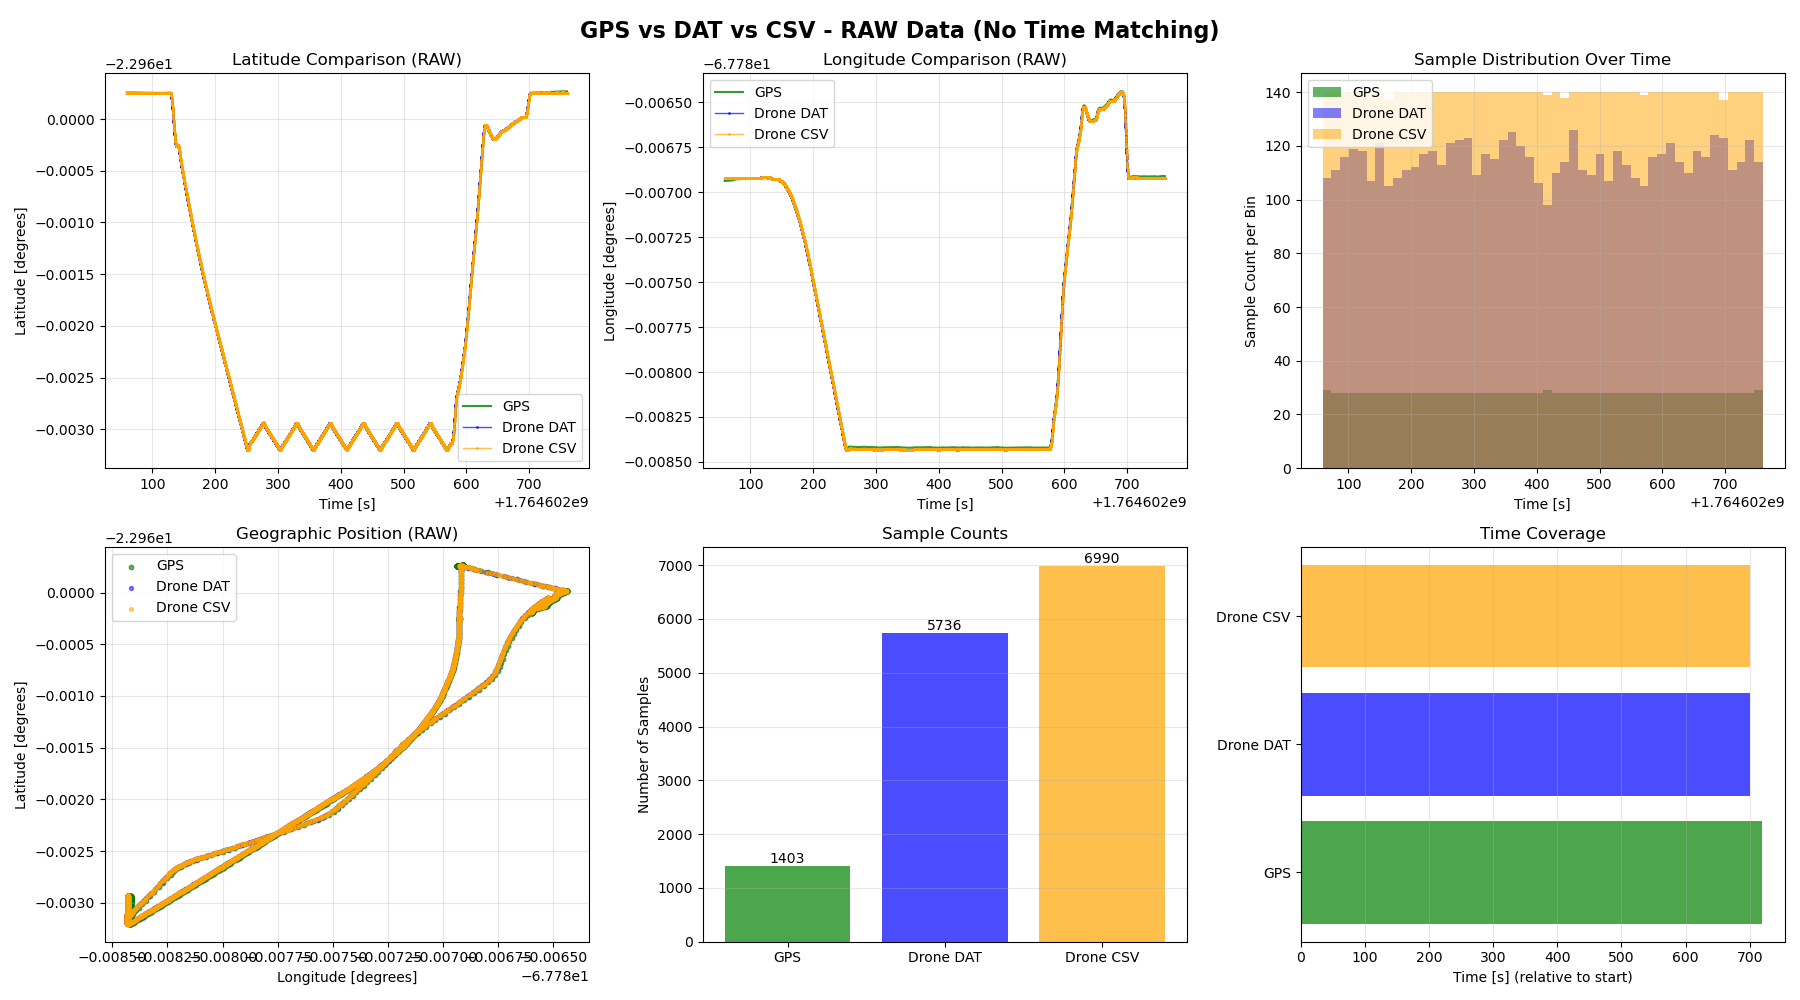

In [14]:
# Generate three-way comparison plot
print("\n" + "="*60)
print("THREE-WAY COMPARISON: GPS vs DAT vs CSV")
print("="*60)
fig = plot_three_way_comparison(gps_df, drone_sources)